In [1]:
from pathlib import Path
from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matchers_metrics import random_homography, AUCMetric, compute_metrics

In [2]:
torch.set_grad_enabled(False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Model device setup: {device}")
extractor = SuperPoint(max_num_keypoints=2000).eval().to(device)
matcher = LightGlue(features="superpoint").eval().to(device)
img_ref = "2.ppm"

Model device setup: cuda


In [3]:
#Carrega a imagem base
img = cv2.imread(img_ref)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
h, w = img_gray.shape

# Gera a homografia aleatória e aplicada a transformação na imagem base
H, pts1, pts2 = random_homography(h, w)
img_warped = cv2.warpPerspective(img, H, (w, h)) #imagem base modificada
img_gray = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)

cv2.imwrite("imagem_rgb.ppm", img_warped)
cv2.imwrite("imagem_gray.ppm", img_gray)

True

In [4]:
image0 = load_image(img_ref)
image1 = load_image("imagem_rgb.ppm")
h, w = image0.shape[1:]

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension
kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

kpts0 = kpts0.cpu().numpy().astype(np.float32)
kpts1 = kpts1.cpu().numpy().astype(np.float32)
kpts1_gt = cv2.perspectiveTransform(kpts0[None, :, :], H)[0]
m_kpts0 = m_kpts0.cpu().numpy().astype(np.float32)
m_kpts1 = m_kpts1.cpu().numpy().astype(np.float32)

bounds = (
    (kpts1_gt[:, 0] >= 0) & (kpts1_gt[:, 0] < w) &
    (kpts1_gt[:, 1] >= 0) & (kpts1_gt[:, 1] < h)
)
kpts0_filtered = kpts0[bounds]
kpts1_gt_filtered = kpts1_gt[bounds]

print(f"Keypoints detectados: {kpts0.shape[0]}")
print(f"Matches preditos:     {matches.shape[0]}")
print(f"Ground truth matches: {kpts1_gt_filtered.shape[0]}")

Keypoints detectados: 2000
Matches preditos:     1378
Ground truth matches: 1634


/home/navms-pdi2/anaconda3/envs/matcherz/lib/python3.10/site-packages/lightglue/viz2d.py:116: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(k[:, 0], k[:, 1], c=c, s=ps, linewidths=0, alpha=alpha)


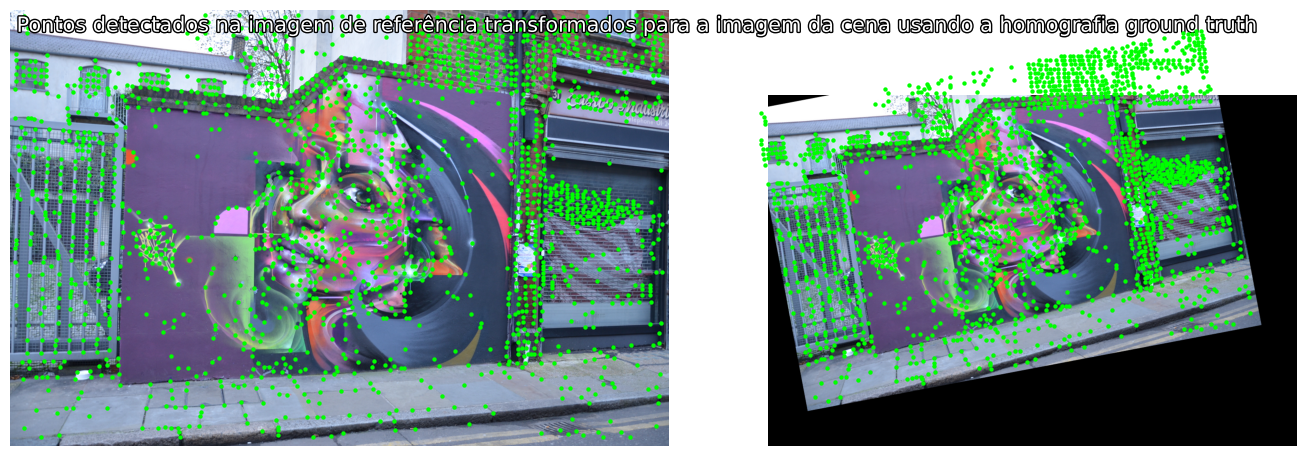

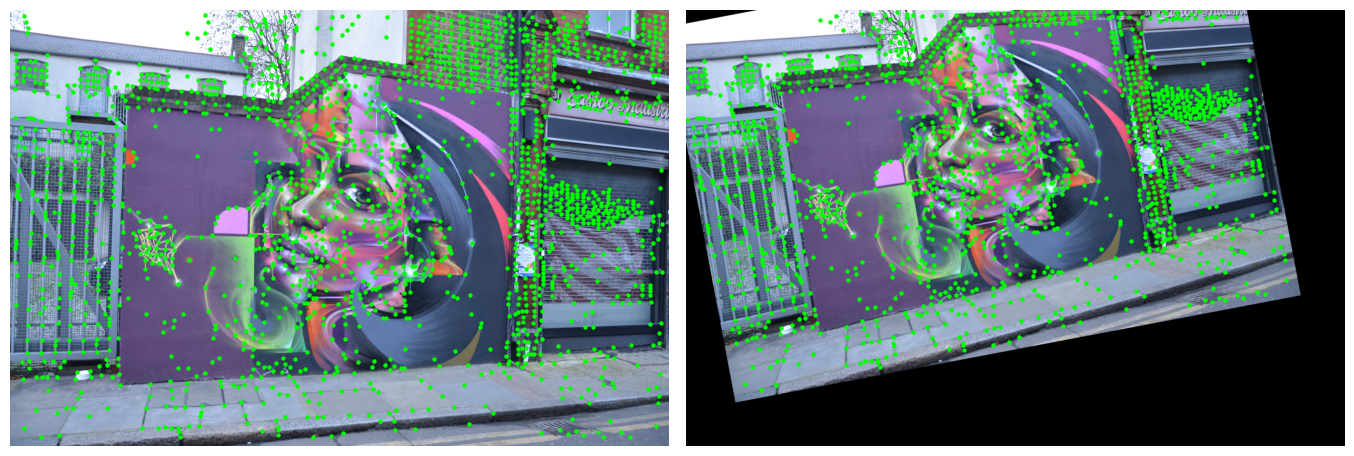

In [5]:
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1_gt], colors=[[0.0, 1.0, 0.0, 1.0],[0.0, 1.0, 0.0, 1.0]], ps=10)
viz2d.add_text(0, f'Pontos detectados na imagem de referência transformados para a imagem da cena usando a homografia ground truth', fs=15)

viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1_gt_filtered], colors=[[0.0, 1.0, 0.0, 1.0],[0.0, 1.0, 0.0, 1.0]], ps=10)

In [6]:
auc_metric = AUCMetric(thresholds=[1, 5])
# Calcula erro médio
H_gt = H
H_est, _ = cv2.findHomography(m_kpts0, m_kpts1, cv2.RANSAC,5.0)

mean_err = auc_metric.compute_mean_reprojection_error(H_est, H_gt, image0.shape[1:])
print("Mean reprojection error:", mean_err)

# Atualiza e calcula AUC
auc_metric.update(torch.tensor([mean_err]))
auc_ransac = auc_metric.compute_ransac()
auc_dlt = auc_metric.compute_dlt([(m_kpts0, m_kpts1, H_gt)], image0.shape[1:])
print(auc_ransac)
print(auc_dlt)

Mean reprojection error: 0.5022315825657598
{'AUC-RANSAC@1px': 0.7489, 'AUC-RANSAC@5px': 0.9498}
{'AUC-DLT@1px': 0.8606, 'AUC-DLT@5px': 0.9721}


In [7]:
report = compute_metrics(m_kpts1, kpts1_gt_filtered, threshold=3.0)
report

{'precision@3px': 92.98,
 'recall@3px': 78.37,
 'mean_error': 95.65,
 'tp': 1337,
 'fp': 101,
 'fn': 369}